# Tacotron2
- https://github.com/NVIDIA/tacotron2

In [174]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from hparams import create_hparams
from model import Tacotron2, Encoder, Decoder, Prenet, Attention
from data_utils import TextMelLoader, TextMelCollate
from utils import load_filepaths_and_text, load_wav_to_torch, get_mask_from_lengths
from layers import TacotronSTFT, LinearNorm
from text import text_to_sequence, sequence_to_text


import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyperparameters

In [2]:
hparams = create_hparams(None)

In [3]:
for k, v in hparams.values().items():
    print('%s: %s' % (k, v))

epochs: 500
iters_per_checkpoint: 500
seed: 1234
dynamic_loss_scaling: True
fp16_run: False
distributed_run: False
dist_backend: nccl
dist_url: file://distributed.dpt
cudnn_enabled: True
cudnn_benchmark: False
load_mel_from_disk: True
training_files: filelists/ljs_audio_text_train_filelist.txt
validation_files: filelists/ljs_audio_text_val_filelist.txt
text_cleaners: ['english_cleaners']
sort_by_length: False
max_wav_value: 32768.0
sampling_rate: 22050
filter_length: 1024
hop_length: 256
win_length: 1024
n_mel_channels: 80
mel_fmin: 0.0
mel_fmax: None
n_symbols: 149
symbols_embedding_dim: 512
encoder_kernel_size: 5
encoder_n_convolutions: 3
encoder_embedding_dim: 512
n_frames_per_step: 1
decoder_rnn_dim: 1024
prenet_dim: 256
max_decoder_steps: 1000
gate_threshold: 0.6
attention_rnn_dim: 1024
attention_dim: 128
attention_location_n_filters: 32
attention_location_kernel_size: 31
postnet_embedding_dim: 512
postnet_kernel_size: 5
postnet_n_convolutions: 5
use_saved_learning_rate: False
lea

## Model

In [4]:
model = Tacotron2(hparams).to('cpu')

/Users/koichiro.mori/git/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))
/Users/koichiro.mori/git/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


In [5]:
model

Tacotron2(
  (embedding): Embedding(149, 512)
  (encoder): Encoder(
    (dropout): Dropout(p=0.5)
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (

In [6]:
print(model.mask_padding)
print(model.fp16_run)
print(model.n_mel_channels)
print(model.n_frames_per_step)

False
False
80
1


In [7]:
print(hparams.n_symbols)
print(hparams.symbols_embedding_dim)

149
512


In [8]:
embedding = nn.Embedding(149, 512)
embedding

Embedding(149, 512)

In [9]:
encoder = Encoder(hparams)

/Users/koichiro.mori/git/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))


In [10]:
print(hparams.encoder_n_convolutions)
print(hparams.encoder_embedding_dim)
print(hparams.encoder_kernel_size)

3
512
5


In [11]:
class ConvNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)
        
        self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)
        
        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain)
        )
    
    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal

In [12]:
convolutions = []
for _ in range(3):
    conv_layer = nn.Sequential(
        ConvNorm(512, 512, kernel_size=5, stride=1, padding=2, dilation=1, w_init_gain='relu'),
        nn.BatchNorm1d(512)
    )
    convolutions.append(conv_layer)

In [13]:
convolutions = nn.ModuleList(convolutions)

In [14]:
convolutions

ModuleList(
  (0): Sequential(
    (0): ConvNorm(
      (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): ConvNorm(
      (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): ConvNorm(
      (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [15]:
lstm = nn.LSTM(512, 256, 1, batch_first=True, bidirectional=True)

In [16]:
lstm

LSTM(512, 256, batch_first=True, bidirectional=True)

## DataLoader

In [17]:
hparams.training_files

'filelists/ljs_audio_text_train_filelist.txt'

In [18]:
trainset = TextMelLoader(hparams.training_files, hparams)

In [19]:
len(trainset)

12500

In [20]:
audiopaths_and_text = load_filepaths_and_text(hparams.training_files, hparams)

In [21]:
audiopaths_and_text[:10]

[['./LJSpeech-1.1/wavs/LJ037-0003.wav', 'Eyewitnesses'],
 ['./LJSpeech-1.1/wavs/LJ043-0159.wav', 'Answer: Yes.'],
 ['./LJSpeech-1.1/wavs/LJ006-0281.wav', 'in some yards'],
 ['./LJSpeech-1.1/wavs/LJ032-0100.wav', 'Marina Oswald'],
 ['./LJSpeech-1.1/wavs/LJ031-0024.wav', 'Gene C. Akin;'],
 ['./LJSpeech-1.1/wavs/LJ011-0028.wav', 'In his defense'],
 ['./LJSpeech-1.1/wavs/LJ012-0199.wav', 'After a little'],
 ['./LJSpeech-1.1/wavs/LJ037-0219.wav', "Oswald's Jacket"],
 ['./LJSpeech-1.1/wavs/LJ040-0062.wav', 'The Early Years'],
 ['./LJSpeech-1.1/wavs/LJ033-0135.wav', 'Location of Bag']]

In [22]:
print(hparams.text_cleaners)
print(hparams.max_wav_value)
print(hparams.sampling_rate)
print(hparams.load_mel_from_disk)

['english_cleaners']
32768.0
22050
True


In [23]:
print(hparams.filter_length)
print(hparams.hop_length)
print(hparams.win_length)
print(hparams.n_mel_channels)
print(hparams.sampling_rate)
print(hparams.mel_fmin)
print(hparams.mel_fmax)

1024
256
1024
80
22050
0.0
None


In [24]:
stft = TacotronSTFT(1024, 256, 1024, 80, 22050, 0.0, None)

In [25]:
index = 0
audiopaths_and_text[index]

['./LJSpeech-1.1/wavs/LJ037-0003.wav', 'Eyewitnesses']

In [26]:
audiopath, text = audiopaths_and_text[10][0], audiopaths_and_text[10][1]
print(audiopath)
print(text)

./LJSpeech-1.1/wavs/LJ038-0003.wav
Oswald's Arrest


In [27]:
print(hparams.text_cleaners)

['english_cleaners']


In [28]:
seq = text_to_sequence(text, ['english_cleaners'])
seq

[42, 46, 50, 28, 39, 31, 55, 46, 64, 28, 45, 45, 32, 46, 47, 1]

In [29]:
t = sequence_to_text(seq)
t

"oswald's arrest~"

- `hparams.load_mel_from_disk` はTrueになっているがなぜ動く？音声ファイルが入力だからFalseにしないと動かないはず

In [30]:
audio = load_wav_to_torch(audiopath, 22050)

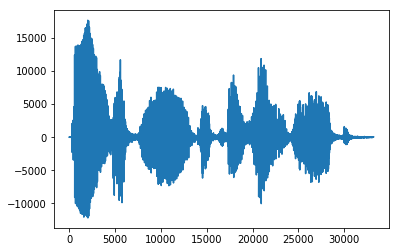

In [31]:
plt.plot(audio.numpy())

In [32]:
print(hparams.max_wav_value)
# -1から1に標準化
audio_norm = audio / hparams.max_wav_value

32768.0


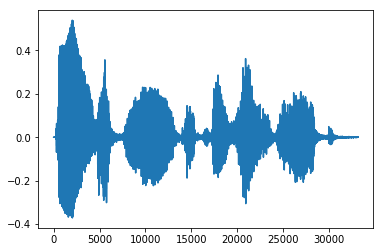

In [33]:
plt.plot(audio_norm.numpy())

In [34]:
audio_norm = audio_norm.unsqueeze(0)

In [35]:
audio_norm.size()

torch.Size([1, 33181])

In [36]:
melspec = stft.mel_spectrogram(audio_norm)

In [37]:
melspec.size()

torch.Size([1, 80, 130])

In [38]:
melspec = torch.squeeze(melspec, 0)
melspec.size()

torch.Size([80, 130])

- 入力となるメルスペクトログラムの次元は [mel, frame]
- frame長は入力となる波形のサイズによって異なる

In [39]:
hparams.load_mel_from_disk = False

In [40]:
trainset = TextMelLoader(hparams.training_files, hparams)

In [41]:
text, mel = trainset[0]

In [42]:
text.size()

torch.Size([107])

In [43]:
mel.size()

torch.Size([80, 749])

## collate_fn: ミニバッチごとに入力データが同じサイズになるようにpaddingする処理

In [44]:
collate_fn = TextMelCollate(hparams.n_frames_per_step)

In [45]:
train_loader = DataLoader(trainset, shuffle=False, batch_size=4, pin_memory=False, drop_last=True, collate_fn=collate_fn)

In [46]:
text_padded, input_lengths, mel_padded, gate_padded, output_lengths = iter(train_loader).next()

In [47]:
print(text_padded.size())
print(input_lengths)
print(mel_padded.size())
print(gate_padded.size())
print(output_lengths)

torch.Size([4, 107])
tensor([ 107,   95,   67,   60])
torch.Size([4, 80, 750])
torch.Size([4, 750])
tensor([ 749,  515,  376,  319])


In [48]:
# collate_fnの調査用のミニバッチ
d1 = trainset[0]
d2 = trainset[1]
d3 = trainset[4]
d4 = trainset[5]

In [49]:
batch = [d1, d2, d3, d4]

In [50]:
len(batch)

4

In [51]:
# 各テキストの長さ
[len(x[0]) for x in batch]

[107, 60, 121, 107]

In [52]:
torch.LongTensor([107, 60, 121, 107])

tensor([ 107,   60,  121,  107])

In [53]:
# input_lenghtsは降順ソートしたテキストの長さのリスト
# 元のインデックス
input_lengths, ids_sorted_decreasing = torch.sort(torch.LongTensor([107, 60, 121, 107]), dim=0, descending=True)

In [54]:
input_lengths

tensor([ 121,  107,  107,   60])

In [55]:
ids_sorted_decreasing

tensor([ 2,  0,  3,  1])

In [56]:
max_input_len = input_lengths[0]

In [57]:
max_input_len

tensor(121)

In [58]:
text_padded = torch.LongTensor(len(batch), max_input_len)

In [59]:
text_padded.size()

torch.Size([4, 121])

In [60]:
for i in range(len(ids_sorted_decreasing)):
    text = batch[ids_sorted_decreasing[i]][0]
    text_padded[i, :text.size(0)] = text

In [61]:
text_padded

tensor([[ 4.7000e+01,  4.2000e+01,  6.4000e+01,  4.7000e+01,  3.5000e+01,
          3.2000e+01,  6.4000e+01,  4.6000e+01,  4.2000e+01,  4.9000e+01,
          3.6000e+01,  3.2000e+01,  4.7000e+01,  6.4000e+01,  3.2000e+01,
          4.0000e+01,  2.9000e+01,  2.8000e+01,  4.6000e+01,  4.6000e+01,
          5.2000e+01,  6.4000e+01,  3.6000e+01,  4.1000e+01,  6.4000e+01,
          5.0000e+01,  2.8000e+01,  4.6000e+01,  3.5000e+01,  3.6000e+01,
          4.1000e+01,  3.4000e+01,  4.7000e+01,  4.2000e+01,  4.1000e+01,
          5.8000e+01,  6.4000e+01,  3.5000e+01,  3.2000e+01,  6.4000e+01,
          2.8000e+01,  4.6000e+01,  3.8000e+01,  3.2000e+01,  3.1000e+01,
          6.4000e+01,  2.8000e+01,  2.9000e+01,  4.2000e+01,  4.8000e+01,
          4.7000e+01,  6.4000e+01,  4.7000e+01,  3.5000e+01,  3.2000e+01,
          6.4000e+01,  3.2000e+01,  4.1000e+01,  4.7000e+01,  4.5000e+01,
          2.8000e+01,  4.1000e+01,  3.0000e+01,  3.2000e+01,  6.4000e+01,
          4.9000e+01,  3.6000e+01,  4.

In [62]:
batch[0][1].size()

torch.Size([80, 749])

In [63]:
num_mels = batch[0][1].size(0)
num_mels

80

In [64]:
# ミニバッチ内のメルスペクトログラムの系列長
[x[1].size(1) for x in batch]

[749, 319, 635, 543]

In [65]:
max_target_len = max([749, 319, 635, 543]) + 1

In [66]:
max_target_len

750

In [67]:
hparams.n_frames_per_step

1

In [68]:
max_target_len % hparams.n_frames_per_step

0

In [69]:
mel_padded = torch.FloatTensor(len(batch), num_mels, max_target_len)
mel_padded.zero_()
mel_padded.size()

torch.Size([4, 80, 750])

In [70]:
# これは何に使う？ 系列長の長さのバッチみたい
# 0でpaddingしたところを1にしている？
gate_padded = torch.FloatTensor(len(batch), max_target_len)
gate_padded.zero_()
gate_padded.size()

torch.Size([4, 750])

In [71]:
# オリジナルの系列長
output_lengths = torch.LongTensor(len(batch))
output_lengths.size()

torch.Size([4])

In [72]:
# テキストのソート順
ids_sorted_decreasing

tensor([ 2,  0,  3,  1])

In [73]:
for i in range(len(ids_sorted_decreasing)):
    mel = batch[ids_sorted_decreasing[i]][1]
    mel_padded[i, :, :mel.size(1)] = mel
    gate_padded[i, mel.size(1):] = 1  # paddingしたところを1にしている？
    output_lengths[i] = mel.size(1)

In [74]:
mel_padded.size()

torch.Size([4, 80, 750])

In [75]:
output_lengths

tensor([ 635,  749,  543,  319])

In [76]:
train_loader = DataLoader(trainset, shuffle=True, batch_size=4, pin_memory=False, drop_last=True, collate_fn=collate_fn)

In [77]:
text_padded, input_lengths, mel_padded, gate_padded, output_lengths = iter(train_loader).next()
print(text_padded.size(), input_lengths, mel_padded.size(), gate_padded.size(), output_lengths.size(), output_lengths)

torch.Size([4, 116]) tensor([ 116,  115,  106,   63]) torch.Size([4, 80, 676]) torch.Size([4, 676]) torch.Size([4]) tensor([ 611,  675,  574,  346])


In [78]:
text_padded, input_lengths, mel_padded, gate_padded, output_lengths = iter(train_loader).next()
print(text_padded.size(), input_lengths, mel_padded.size())

torch.Size([4, 158]) tensor([ 158,  138,   72,   19]) torch.Size([4, 80, 832])


In [79]:
for i, batch in enumerate(train_loader):
    print(i, batch[0].size(), batch[1].size(), batch[2].size(), batch[3].size(), batch[4].size())
    break

0 torch.Size([4, 108]) torch.Size([4]) torch.Size([4, 80, 547]) torch.Size([4, 547]) torch.Size([4])


## Train

- batchは (text_padded, input_lengths, mel_padded, gate_padded, output_lenghts) の5つ組
- text_padded: zero paddingされたテキスト系列 (batch, text_length)
- input_lengths: テキストのオリジナルの系列長 (batch, )
- mel_padded: メルスペクトログラムのzero paddingされた系列長 (batch, num_mels, frame)
- gate_padded: メルスペクトログラムでzero paddingされたところが1 (batch, frame)
- output_lengths: メルスペクトログラムのオリジナルの系列長 (batch, )

In [80]:
batch = iter(train_loader).next()
print(batch[0].size(), batch[1].size(), batch[2].size(), batch[3].size(), batch[4].size())

torch.Size([4, 163]) torch.Size([4]) torch.Size([4, 80, 780]) torch.Size([4, 780]) torch.Size([4])


In [81]:
from model import Tacotron2, Encoder
model = Tacotron2(hparams).to('cpu')

/Users/koichiro.mori/git/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))
/Users/koichiro.mori/git/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


In [82]:
batch_parser = model.parse_batch

In [83]:
x, y = batch_parser(batch)

In [84]:
print(x[0].size())
print(x[1].size(), x[1])
print(x[2].size())
print(x[3])  # maxlen
print(x[4].size(), x[4])

torch.Size([4, 163])
torch.Size([4]) tensor([ 163,  121,  100,   76])
torch.Size([4, 80, 780])
163
torch.Size([4]) tensor([ 779,  697,  627,  514])


In [85]:
print(y[0].size())
print(y[1].size())

torch.Size([4, 80, 780])
torch.Size([4, 780])


- x: text_padded, input_lengths, mel_padded, max(input_lenghts), output_lengths
- y: mel_padded, gate_padded

In [86]:
from model import Tacotron2, Encoder
model = Tacotron2(hparams).to('cpu')

/Users/koichiro.mori/git/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))
/Users/koichiro.mori/git/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


In [87]:
model(x)

*** x: torch.Size([4, 512, 163])
*** input_lengths: tensor([ 163,  121,  100,   76])
*** conv: torch.Size([4, 512, 163])
*** conv: torch.Size([4, 512, 163])
*** conv: torch.Size([4, 512, 163])
*** transpose: torch.Size([4, 163, 512])
*** torch.Size([460, 512])
*** outputs: torch.Size([460, 512])
*** output: torch.Size([4, 163, 512])
*** memory: torch.Size([4, 163, 512])
*** decoder_input: torch.Size([4, 80])
attention_hidden: torch.Size([4, 1024])
attention_cell: torch.Size([4, 1024])
decoder_hidden: torch.Size([4, 1024])
decoder_cell: torch.Size([4, 1024])
attention_weights: torch.Size([4, 163])
attention_weights_cum: torch.Size([4, 163])
attention_context: torch.Size([4, 512])


[tensor([[[-4.2111e-03, -7.8068e-02, -2.2712e-01,  ..., -1.5912e-01,
           -4.3394e-01, -3.6552e-01],
          [-5.8458e-02, -9.1870e-02,  8.7890e-02,  ..., -1.5803e-01,
           -2.1279e-01, -2.7359e-01],
          [ 5.6512e-02,  3.1115e-01,  9.8136e-03,  ..., -6.4732e-03,
           -4.1777e-02,  4.4706e-02],
          ...,
          [-1.3845e-01,  7.1028e-02, -2.9720e-01,  ..., -4.4055e-02,
           -1.1924e-01,  2.1763e-01],
          [-7.3988e-02, -2.6394e-01, -2.1377e-01,  ...,  1.1835e-01,
            1.0732e-01, -5.9689e-02],
          [-2.0237e-03,  7.8121e-02, -2.2514e-01,  ..., -3.9958e-01,
           -3.1027e-01, -4.8566e-01]],
 
         [[-1.4365e-02, -1.7603e-01, -4.1345e-01,  ..., -4.3732e-02,
           -4.3734e-02, -4.3737e-02],
          [-4.1823e-02, -6.0722e-02, -6.5373e-02,  ..., -6.1569e-02,
           -6.1569e-02, -6.1569e-02],
          [ 7.3492e-02,  1.6417e-01,  1.7069e-01,  ...,  7.7085e-02,
            7.7085e-02,  7.7085e-02],
          ...,
    

In [88]:
inputs, input_lengths, targets, max_len, output_lengths = batch

In [89]:
input_lengths, output_lengths = input_lengths.data, output_lengths.data

In [90]:
print(input_lengths)   # テキストの系列長　
print(output_lengths)  # メルスペクトログラムの系列長

tensor([ 163,  121,  100,   76])
tensor([ 779,  697,  627,  514])


In [91]:
embedded_inputs = model.embedding(inputs).transpose(1, 2)

In [92]:
embedded_inputs.size()  # [batch, feature, seq] PyTorchのConv1dの入力サイズ

torch.Size([4, 512, 163])

### Encoder

In [93]:
from model import Tacotron2, Encoder
model = Tacotron2(hparams).to('cpu')

/Users/koichiro.mori/git/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))
/Users/koichiro.mori/git/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


In [94]:
print(embedded_inputs.size())
print(input_lengths)

torch.Size([4, 512, 163])
tensor([ 163,  121,  100,   76])


In [95]:
encoder_outputs = model.encoder(embedded_inputs, input_lengths)

*** x: torch.Size([4, 512, 163])
*** input_lengths: tensor([ 163,  121,  100,   76])
*** conv: torch.Size([4, 512, 163])
*** conv: torch.Size([4, 512, 163])
*** conv: torch.Size([4, 512, 163])
*** transpose: torch.Size([4, 163, 512])
*** torch.Size([460, 512])
*** outputs: torch.Size([460, 512])
*** output: torch.Size([4, 163, 512])


In [96]:
encoder_outputs.size()

torch.Size([4, 163, 512])

In [97]:
lstm = nn.LSTM(512, 256, 1, batch_first=True, bidirectional=True)
lstm

LSTM(512, 256, batch_first=True, bidirectional=True)

- flatten_parameters()はマルチGPUで必要な処理？

In [98]:
lstm.flatten_parameters()
lstm

LSTM(512, 256, batch_first=True, bidirectional=True)

### Decoder

In [137]:
# decoderのattention weightsを計算するのに使われる
encoder_outputs.size()

torch.Size([4, 163, 512])

In [138]:
targets.size()

torch.Size([4, 80, 780])

In [101]:
memory_lengths = input_lengths
memory_lengths  # バッチを構成する入力テキストの系列長

tensor([ 163,  121,  100,   76])

In [139]:
print(hparams.n_mel_channels)
print(hparams.n_frames_per_step)
print(hparams.encoder_embedding_dim)
print(hparams.attention_rnn_dim)
print(hparams.decoder_rnn_dim)
print(hparams.prenet_dim)
print(hparams.max_decoder_steps)
print(hparams.gate_threshold)

80
1
512
1024
1024
256
1000
0.6


In [150]:
memory = encoder_outputs  # エンコーダの出力（テキスト特徴量）
decoder_inputs = targets  # メルスペクトログラム（出力となる）
memory_lengths = input_lengths  # バッチを構成する入力テキストの系列長

In [151]:
print(memory.size())
print(decoder_inputs.size())
print(memory_lengths)

torch.Size([4, 163, 512])
torch.Size([4, 80, 780])
tensor([ 163,  121,  100,   76])


In [152]:
decoder = Decoder(hparams)

/Users/koichiro.mori/git/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))
/Users/koichiro.mori/git/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))


In [153]:
decoder_input = decoder.get_go_frame(memory)
decoder_input.size()

torch.Size([4, 80])

In [154]:
decoder_inputs = decoder.parse_decoder_inputs(decoder_inputs)

In [155]:
decoder_inputs.size()  # (seqlen, batch, features)

torch.Size([780, 4, 80])

In [149]:
decoder_inputs

tensor([[[ -7.9470,  -7.1068,  -6.4366,  ...,  -8.7415,  -8.6529,
           -9.1134],
         [ -8.1235,  -6.3942,  -5.8867,  ...,  -9.5579,  -9.6605,
           -9.8809],
         [ -6.8018,  -5.8457,  -6.0552,  ...,  -8.8050,  -9.2375,
          -10.5610],
         [ -6.1744,  -6.3822,  -6.3996,  ...,  -9.9191, -10.0493,
          -10.8555]],

        [[ -7.6436,  -7.0450,  -6.1906,  ...,  -8.3608,  -8.2883,
           -9.1178],
         [ -8.2578,  -6.6928,  -5.9495,  ...,  -9.4310,  -9.6945,
           -9.8029],
         [ -6.3901,  -5.9171,  -5.2944,  ...,  -5.7075,  -6.1652,
           -8.0939],
         [ -6.6239,  -6.7819,  -5.7135,  ...,  -9.4868,  -9.9183,
          -10.5577]],

        [[ -7.1368,  -6.2999,  -5.3963,  ...,  -6.9938,  -7.5920,
           -9.2136],
         [ -8.3706,  -7.0172,  -6.5367,  ...,  -9.5467,  -9.5898,
          -10.1134],
         [ -7.2332,  -6.1908,  -5.3871,  ...,  -4.8795,  -5.3569,
           -7.0563],
         [ -6.3462,  -5.8769,  -5.1226,

In [109]:
memory.size()

torch.Size([4, 163, 512])

In [110]:
memory_lengths

tensor([ 163,  121,  100,   76])

In [111]:
mask = ~get_mask_from_lengths(memory_lengths)

In [112]:
mask[0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=torch.uint8)

In [113]:
mask[1]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1], dtype=torch.uint8)

In [114]:
mask[2]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1], dtype=torch.uint8)

In [115]:
decoder.initialize_decoder_states(memory, mask=mask)

attention_hidden: torch.Size([4, 1024])
attention_cell: torch.Size([4, 1024])
decoder_hidden: torch.Size([4, 1024])
decoder_cell: torch.Size([4, 1024])
attention_weights: torch.Size([4, 163])
attention_weights_cum: torch.Size([4, 163])
attention_context: torch.Size([4, 512])


In [116]:
mel_outputs, gate_outputs, alignments = [], [], []

In [117]:
decoder_inputs.size(0)

780

In [118]:
memory = encoder_outputs  # テキスト特徴量
decoder_inputs = targets  # メルスペクトログラム（出力となる）
memory_lengths = input_lengths  # バッチを構成する入力テキストの系列長
print(memory.size())
print(decoder_inputs.size())
print(memory_lengths)

decoder(memory, decoder_inputs, memory_lengths)

torch.Size([4, 163, 512])
torch.Size([4, 80, 780])
tensor([ 163,  121,  100,   76])
*** memory: torch.Size([4, 163, 512])
*** decoder_input: torch.Size([4, 80])
attention_hidden: torch.Size([4, 1024])
attention_cell: torch.Size([4, 1024])
decoder_hidden: torch.Size([4, 1024])
decoder_cell: torch.Size([4, 1024])
attention_weights: torch.Size([4, 163])
attention_weights_cum: torch.Size([4, 163])
attention_context: torch.Size([4, 512])


(tensor([[[-4.7202e-02, -6.2895e-01, -2.5581e-01,  ..., -6.3293e-01,
           -4.0786e-01, -7.2768e-01],
          [ 1.8926e-02,  2.9120e-01,  6.4308e-02,  ..., -6.7519e-02,
            4.3046e-02,  2.2482e-01],
          [ 5.4296e-02, -7.4026e-02, -3.6574e-02,  ...,  1.8612e-01,
           -1.8707e-01, -2.3050e-02],
          ...,
          [ 1.0338e-01, -2.2023e-01, -8.3709e-03,  ..., -6.3593e-02,
            1.8228e-01, -2.5440e-01],
          [-2.0900e-02,  5.4765e-02, -1.7301e-02,  ...,  7.2265e-02,
            1.7886e-01,  3.1559e-01],
          [ 1.5614e-02, -8.7630e-02, -6.7494e-02,  ..., -2.3097e-01,
           -1.7160e-01, -3.0105e-01]],
 
         [[-4.7354e-02,  2.2333e-01, -3.3355e-01,  ..., -4.8253e-02,
           -4.8250e-02, -4.8247e-02],
          [ 1.7266e-02, -4.4502e-02,  5.4839e-01,  ...,  2.5642e-02,
            2.5637e-02,  2.5632e-02],
          [ 1.6263e-02, -1.4340e-02,  2.4605e-01,  ..., -2.1030e-02,
           -2.1035e-02, -2.1039e-02],
          ...,
    

### PreNet

In [119]:
print(hparams.n_mel_channels)
print(hparams.n_frames_per_step)
print(hparams.prenet_dim)
prenet = Prenet(80 * 1, [256, 256])
prenet

80
1
256


/Users/koichiro.mori/git/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


Prenet(
  (layers): ModuleList(
    (0): LinearNorm(
      (linear_layer): Linear(in_features=80, out_features=256, bias=False)
    )
    (1): LinearNorm(
      (linear_layer): Linear(in_features=256, out_features=256, bias=False)
    )
  )
)

In [120]:
print(hparams.decoder_rnn_dim)
print(hparams.encoder_embedding_dim)
print(hparams.attention_rnn_dim)
attention_rnn = nn.LSTMCell(1024 + 512, 1024)
attention_rnn

1024
512
1024


LSTMCell(1536, 1024)

In [121]:
print(hparams.prenet_dim)
print(hparams.encoder_embedding_dim)
print(hparams.decoder_rnn_dim)
decoder_rnn = nn.LSTMCell(256 + 512, 1024, 1)
decoder_rnn

256
512
1024


LSTMCell(768, 1024, bias=1)

In [122]:
print(hparams.decoder_rnn_dim)
print(hparams.encoder_embedding_dim)
print(hparams.n_mel_channels)
linear_projection = LinearNorm(1024 + 512, 80)
linear_projection

1024
512
80


/Users/koichiro.mori/git/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


LinearNorm(
  (linear_layer): Linear(in_features=1536, out_features=80, bias=True)
)

In [123]:
gate_layer = LinearNorm(1024 + 512, 1, bias=True, w_init_gain='sigmoid')

/Users/koichiro.mori/git/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


In [124]:
gate_layer

LinearNorm(
  (linear_layer): Linear(in_features=1536, out_features=1, bias=True)
)

In [125]:
memory.size()

torch.Size([4, 163, 512])

In [126]:
B = memory.size(0)
MAX_TIME = memory.size(1)
B, MAX_TIME

(4, 163)

In [127]:
print(hparams.attention_rnn_dim)
memory.data.new(B, 1024).zero_().size()

1024


torch.Size([4, 1024])

In [128]:
print(memory.size())
print(decoder_inputs.size())
print(memory_lengths)

torch.Size([4, 163, 512])
torch.Size([4, 80, 780])
tensor([ 163,  121,  100,   76])


In [129]:
mel_outputs, gate_outputs, alignments = decoder(memory, decoder_inputs, memory_lengths)

*** memory: torch.Size([4, 163, 512])
*** decoder_input: torch.Size([4, 80])
attention_hidden: torch.Size([4, 1024])
attention_cell: torch.Size([4, 1024])
decoder_hidden: torch.Size([4, 1024])
decoder_cell: torch.Size([4, 1024])
attention_weights: torch.Size([4, 163])
attention_weights_cum: torch.Size([4, 163])
attention_context: torch.Size([4, 512])


In [130]:
print(mel_outputs.size())
print(gate_outputs.size())
print(alignments.size())

torch.Size([4, 80, 780])
torch.Size([4, 780])
torch.Size([4, 780, 163])


In [131]:
hparams.attention_dim

128

In [171]:
print(hparams.attention_rnn_dim)
print(hparams.encoder_embedding_dim)
print(hparams.attention_dim)
print(hparams.attention_location_n_filters)
print(hparams.attention_location_kernel_size)

1024
512
128
32
31


In [175]:
attention_layer = Attention(1024, 512, 128, 32, 31)

/Users/koichiro.mori/git/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))
/Users/koichiro.mori/git/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))


In [176]:
Attention

model.Attention

In [177]:
attention_layer

Attention(
  (query_layer): LinearNorm(
    (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
  )
  (memory_layer): LinearNorm(
    (linear_layer): Linear(in_features=512, out_features=128, bias=False)
  )
  (v): LinearNorm(
    (linear_layer): Linear(in_features=128, out_features=1, bias=False)
  )
  (location_layer): LocationLayer(
    (location_conv): ConvNorm(
      (conv): Conv1d(2, 32, kernel_size=(31,), stride=(1,), padding=(15,), bias=False)
    )
    (location_dense): LinearNorm(
      (linear_layer): Linear(in_features=32, out_features=128, bias=False)
    )
  )
)

In [178]:
memory.size()

torch.Size([4, 163, 512])

In [181]:
# memory_layerは単純なLinear変換
# embedding_dim (512) を attention_dim (128) に次元圧縮している
processed_memory = attention_layer.memory_layer(memory)
processed_memory.size()

torch.Size([4, 163, 128])

In [186]:
# decoderの最初の入力を0で初期化
decoder_input = decoder.get_go_frame(memory)
decoder_input.size()

torch.Size([4, 80])

In [190]:
print(decoder.decoder_hidden.size())
print(decoder.attention_context.size())

torch.Size([4, 1024])
torch.Size([4, 512])


In [193]:
cell_input = torch.cat((decoder.decoder_hidden, decoder.attention_context), -1)
cell_input.size()

torch.Size([4, 1536])

In [198]:
decoder.attention_hidden, decoder.attention_cell = decoder.attention_rnn(cell_input, (decoder.attention_hidden, decoder.attention_cell))

In [200]:
decoder.attention_cell

tensor(1.00000e-02 *
       [[ 1.3329,  0.0715, -1.1153,  ...,  2.9965, -0.5315, -0.6198],
        [ 1.3329,  0.0715, -1.1153,  ...,  2.9965, -0.5315, -0.6198],
        [ 1.3329,  0.0715, -1.1153,  ...,  2.9965, -0.5315, -0.6198],
        [ 1.3329,  0.0715, -1.1153,  ...,  2.9965, -0.5315, -0.6198]])

In [202]:
decoder.attention_rnn

LSTMCell(1536, 1024)